## Data Dictionary


    case_id: ID of each visa application
    continent: Information of continent the employee
    education_of_employee: Information of education of the employee
    has_job_experience: Does the employee has any job experience? Y= Yes; N = No
    requires_job_training: Does the employee require any job training? Y = Yes; N = No
    no_of_employees: Number of employees in the employer's company
    yr_of_estab: Year in which the employer's company was established
    region_of_employment: Information of foreign worker's intended region of employment in the US.
    prevailing_wage: Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
    unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
    full_time_position: Is the position of work full-time? Y = Full-Time Position; N = Part-Time Position
    case_status: Flag indicating if the Visa was certified or denied



In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library to split data
from sklearn.model_selection import train_test_split

# To build model for prediction
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier

# For Oversampling and Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
)

# For HyperParameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# to suppress unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the csv file
df = pd.read_csv("EasyVisa.csv")  # Adjust the path

# copy the data to another variable to avoid changes in the original data
data = df.copy()

# Exploratory Data Analysis

In [3]:
# View the first 5 rows of the dataset
data.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [4]:
#Understand the shape of the dataset
data.shape

(25480, 12)

- The dataset has 25480 rows and 12 columns

In [5]:
# Check the data types of the columns for the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


* There are no null values in the data
* 3 attributes are of numerical data type and 9 attributes are of object data type

In [6]:
# Checking the Statistical Summary
data.describe()

,no_of_employees,yr_of_estab,prevailing_wage
count,25480.000000,25480.000000,25480.000000
mean,5667.043210,1979.409929,74455.814592
std,22877.928848,42.366929,52815.942327
min,-26.000000,1800.000000,2.136700
25%,1022.000000,1976.000000,34015.480000
50%,2109.000000,1997.000000,70308.210000
75%,3504.000000,2005.000000,107735.512500
max,602069.000000,2016.000000,319210.270000


- The distribution of no_of_employees is right skewed showing that some companies have a very large number of employees. It has negative values which need to be handled.
- yr_of_estab ranges from 1800 to 2016. The distribution for this is left skewed.
- As the values of prevailing_wage have different unit_of_wage, it is not sensible to draw conclusions regarding this attribute. We will make changes to this column for futher analysis.

In [7]:
data.duplicated().sum()

np.int64(0)

* There are no duplicated rows in the dataset.

- Let's drop the case_id column before we proceed forward as it is a unique identifier for the rows and will not add value to the analysis.

In [8]:
data = data.drop(["case_id"], axis=1)

* We saw that no_of_employees column had negative values. We will make necessary changes to this column.

In [9]:
# Checking for no_of_employees less than or equal to 0

data[data['no_of_employees'] <= 0]['no_of_employees'].unique()

array([-25, -11, -17, -26, -14])

* We will assume that these negative signs here are data input errors, so we will replace them with positive sign.

In [10]:
data['no_of_employees'] = data['no_of_employees'].abs()

In [11]:
# checking for negative values in no_of_employees column
data[data['no_of_employees'] <= 0]['no_of_employees'].unique()

array([], dtype=int64)

## Feature Engineering

* We will standardize the prevailing_wage column by multiplying the values with different numbers based on the unit_of_wage.

In [12]:
# Function to standardize the prevailing_wage
def standardize_wage(row):
    wage = row['prevailing_wage']
    unit = row['unit_of_wage']

    if unit == 'Hour':
        return wage * 8 * 260  # Assuming 8 hours/day, 260 workdays/year
    elif unit == 'Week':
        return wage * 52       # ~52 Weeks in a year
    elif unit == 'Month':
        return wage * 12       # 12 Months in a year
    elif unit == 'Year':
        return wage
    else:
        return None  # Handle cases with missing or invalid units

# Apply the above function to create a new column: 'annual_wage'
data['annual_wage'] = data.apply(standardize_wage, axis=1)

In [13]:
# View first 5 rows of the data after adding the new column
data.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,annual_wage
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,1231782.032
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,83425.650
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,122996.860
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,83434.030
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,149907.390


- 'annual_wage' column has been added to the dataset.

## Univariate Analysis

In [14]:
# Declaring a list of numerical variables
num_vars = ['no_of_employees', 'yr_of_estab', 'annual_wage']

# Declaring a list of categorical variables
cat_vars = ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment',
            'unit_of_wage', 'full_time_position', 'case_status']

#### Observation on no_of_employees

In [15]:
print('Number of companies having upto ten thousand employees:', data[data['no_of_employees'] <= 10000].shape[0])
print('Number of companies having more than ten thousand and upto one lakh employees:', data[(data['no_of_employees'] > 10000) & (data['no_of_employees'] <= 100000)].shape[0])
print('Number of companies having greater than one lakh employees:', data[data['no_of_employees'] > 100000].shape[0])

Number of companies having upto ten thousand employees: 24044
Number of companies having more than ten thousand and upto one lakh employees: 1165
Number of companies having greater than one lakh employees: 271


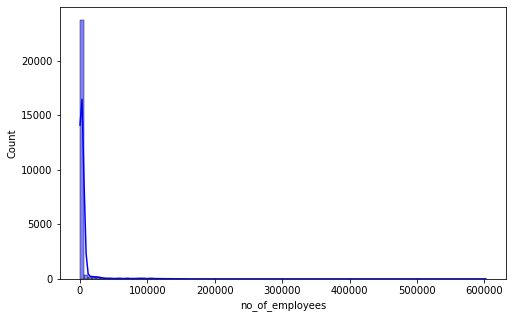

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='no_of_employees', bins=100, kde=True, color='blue')
plt.show()

- The distribution for no_of_employees is highly right skewed with most of the companies having less than 10000 employees.
- Over 24000 companies have number of employees less than or equal to 10000.
- 1165 companies have number of employees more than 10000 and less than a 100000.
- Only 271 companies have number of employees greater than a lakh. We will not replace these outliers since it is possible for the companies to have lakhs of employees.

#### Observation on yr_of_estab

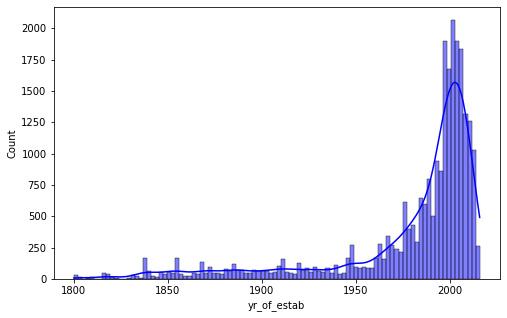

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='yr_of_estab', bins=100, kde=True, color='blue')
plt.show()

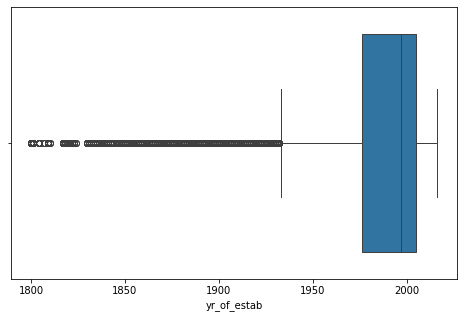

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data,x='yr_of_estab')
plt.show()

- The distribution for yr_of_estab is left-skewed with most of the companies being established after 1990.

#### Observation on annual_wage

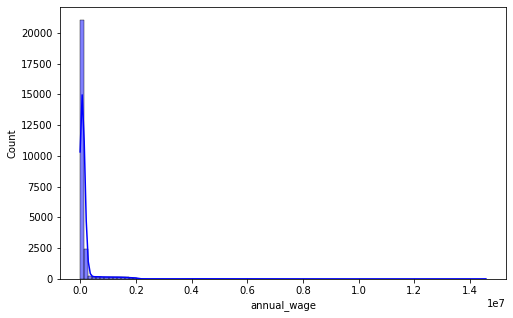

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='annual_wage', bins=100, kde=True, color='blue')
plt.show()

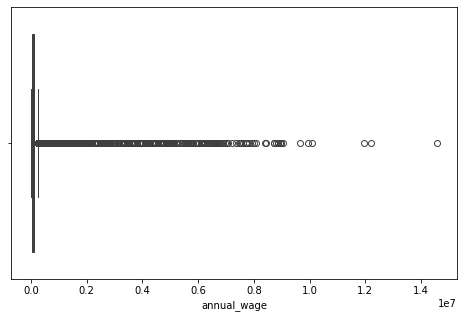

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data,x='annual_wage')
plt.show()

The distribution of annual_wage is highly right skewed with most of the employees having a annual salary of less than two hundred thousand.

#### Observation on continent

In [21]:
data['continent'].value_counts()

continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: count, dtype: int64

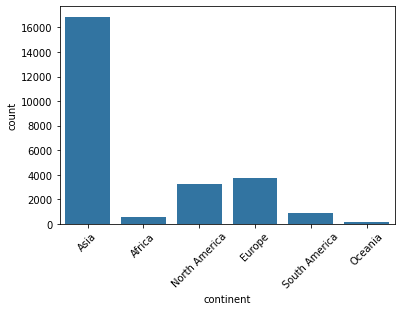

In [22]:
sns.countplot(data = data, x = 'continent')
plt.xticks(rotation=45);

- Most of the applicants are from Asia.
- Very few applicants are from Africa and Oceania.

#### Observation on education_of_employee

In [23]:
data['education_of_employee'].value_counts()

education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64

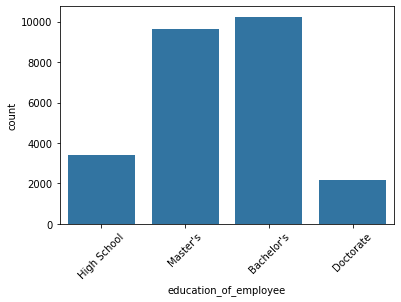

In [24]:
sns.countplot(data = data, x = 'education_of_employee')
plt.xticks(rotation=45);

- Applicants who have completed their Bachelor's or Master's degree are almost triple in numbers compared to those who have completed High School or Doctorate.

#### Observation on has_job_experience

In [25]:
data['has_job_experience'].value_counts()

has_job_experience
Y    14802
N    10678
Name: count, dtype: int64

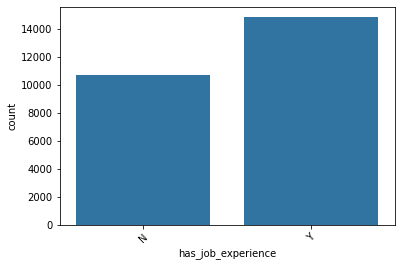

In [26]:
sns.countplot(data = data, x = 'has_job_experience')
plt.xticks(rotation=45);

- 14802 number of applicants have job experience while 10678 don't.

#### Observation on requires_job_training

In [27]:
data['requires_job_training'].value_counts()

requires_job_training
N    22525
Y     2955
Name: count, dtype: int64

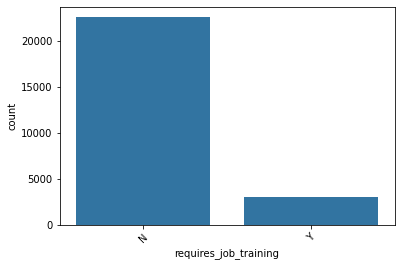

In [28]:
sns.countplot(data = data, x = 'requires_job_training')
plt.xticks(rotation=45);

- Most of the applicants do not require job training. Only ~3000 applicants requre job training.

#### Observation on region_of_employment

In [29]:
data['region_of_employment'].value_counts()

region_of_employment
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: count, dtype: int64

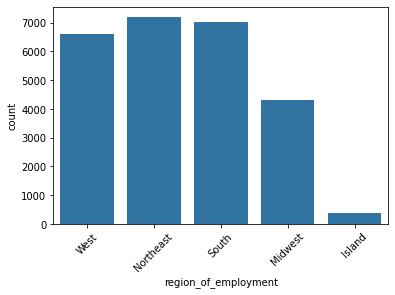

In [30]:
sns.countplot(data = data, x = 'region_of_employment')
plt.xticks(rotation=45);

- Applicants whose employment is in Midwest region are ~4000 and those in Island region is less than 500. These are the least ones.
- All other regions have applicants more than 6000.


#### Observation on unit_of_wage

In [31]:
data['unit_of_wage'].value_counts()

unit_of_wage
Year     22962
Hour      2157
Week       272
Month       89
Name: count, dtype: int64

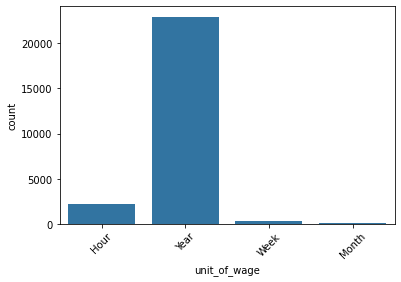

In [32]:
sns.countplot(data = data, x = 'unit_of_wage')
plt.xticks(rotation=45);

- Applicants whose unit of wage is Yearly are the highest: apprx. 23000.
- Those with Hourly wage are apprx. 2000.
- Weekly and montlhly waged workers are very few.

#### Observation on full_time_position

In [33]:
data['full_time_position'].value_counts()

full_time_position
Y    22773
N     2707
Name: count, dtype: int64

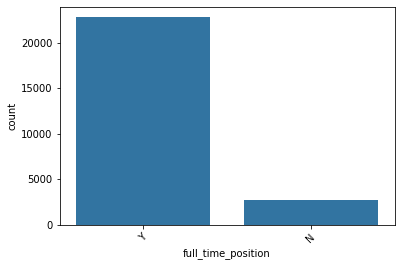

In [34]:
sns.countplot(data = data, x = 'full_time_position')
plt.xticks(rotation=45);

- Most of the applicants have a full time job.
- Only nearly 3000 of them do not have full time job.

#### Observation on case_status (Target Variable)

In [35]:
data['case_status'].value_counts()

case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

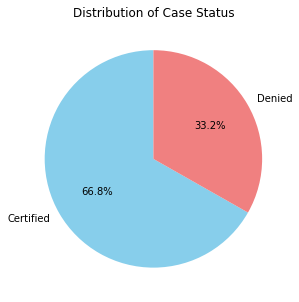

In [36]:
case_counts = data['case_status'].value_counts()

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(case_counts, labels=case_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title("Distribution of Case Status")
plt.show()

- The number of applicants whose Visa was approved is twice the number of applicants whose Visa was not approved.
- The dataset is imbalanced with 'Certified'(class 1) class having high count. So, we will focus on F1 score to evaluate the performance of the models.

## Bivariate Analysis

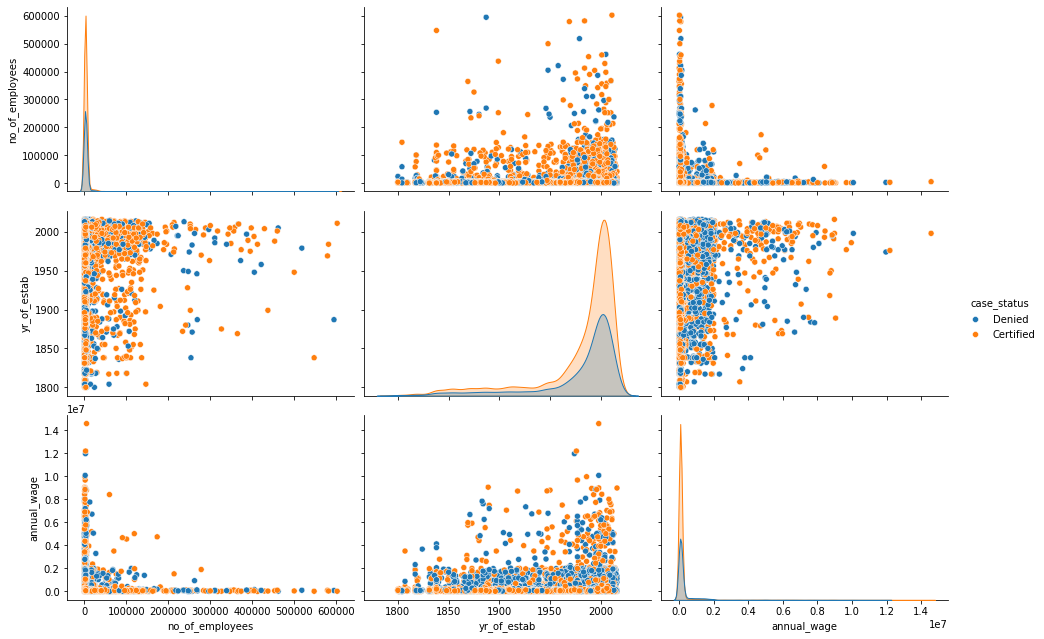

In [37]:
# Pairplot to visualize relationships between numerical variables, colored by 'case_status'

sns.pairplot(data,
             hue='case_status',
             vars=num_vars,
             diag_kind='kde',
             height=3,
             aspect=1.5)
plt.show();

- There seems to be a slight positive correlation between yr_of_estab (year of establishment) and annual_wage, meaning older companies might offer higher wages.
- No clear linear correlation between no_of_employees and annual_wage, but some companies with very high employee counts have high wages.
- Older companies (higher yr_of_estab) seem to have a higher chance of certification.

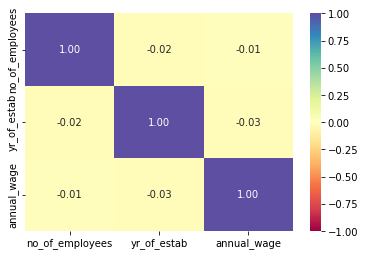

In [38]:
# Create a heatmap to show the correlation between numerical variables

sns.heatmap(data[num_vars].corr(), vmin=-1, fmt='.2f', annot=True, cmap='Spectral');

- The correlation values between no_of_employees, yr_of_estab, and annual_wage are all close to 0, meaning there is almost no linear relationship between these features.
- This suggests that these features are independent and do not influence each other directly.

#### no_of_employees vs case_status

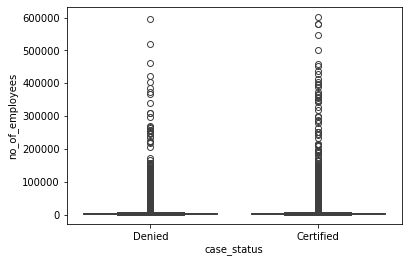

In [39]:
# Create a boxplot to show the case_status distribution for no_of_employees
sns.boxplot(x=data['case_status'], y=data['no_of_employees'])
plt.title('')

# Display the plot
plt.show()

- The interquartile range is very small, meaning most companies have a similar range of employees.
- Since both categories (Certified and Denied) follow almost the same distribution, this suggests that the number of employees may not be a strong predictor of visa approval.

#### yr_of_estab vs case_status

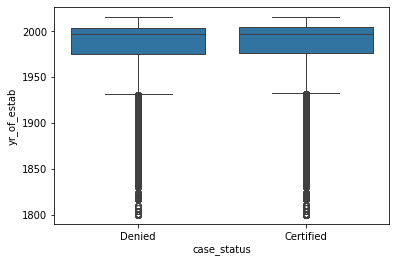

In [40]:
# Create a boxplot to show the case_status distribution for no_of_employees
sns.boxplot(x=data['case_status'], y=data['yr_of_estab'])
plt.title('')

# Display the plot
plt.show()

- The median year of establishment for both Certified and Denied cases is around 2000, indicating that most companies in the dataset were established in the last few decades.The interquartile range (IQR) is also nearly identical for both categories.
- Older companies are present in both categories, meaning longevity does not significantly impact visa certification likelihood.

#### annual_wage vs case_status

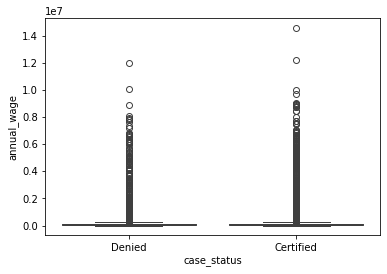

In [41]:
# Create a boxplot to show the case_status distribution for no_of_employees
sns.boxplot(x=data['case_status'], y=data['annual_wage'])
plt.title('')

# Display the plot
plt.show()

- Several cases have extremely high annual wages (over $10 million). These high-wage outliers exist in both Certified and Denied cases.
- Since both distributions are nearly the same, higher wages do not necessarily increase the likelihood of visa certification.Companies offering both low and high salaries have both approved and denied applications.

#### Continent vs case_status

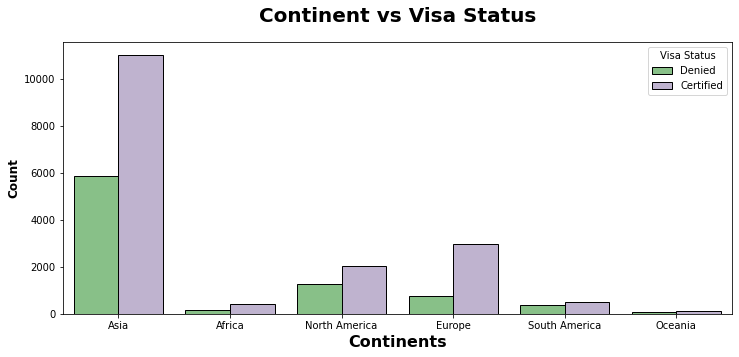

In [42]:
plt.subplots(figsize=(12,5))
sns.countplot(x="continent",hue="case_status", data=data, ec = "black",palette="Accent")
plt.title("Continent vs Visa Status", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=12)
plt.xlabel("Continents", weight="bold", fontsize=16)
plt.legend(title="Visa Status", fancybox=True)
plt.show()

- Asia has the highest number of applicants, with a significant portion certified. However, it also has the highest number of denials, suggesting a higher rejection rate.
- Europe and North America have a smaller but balanced number of applications.
- South America and Oceania seem to have more Denied applications in proportion with Certified applications when compared to others.

#### education_of_employee vs case_status

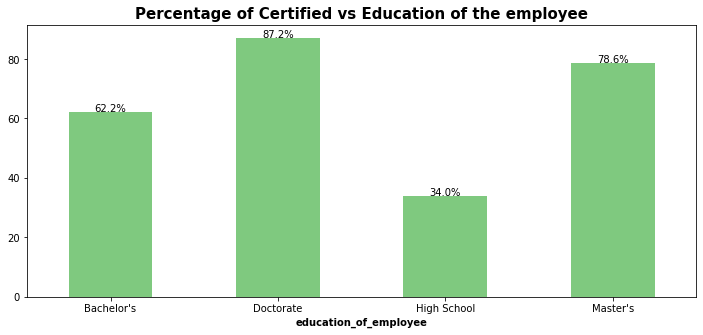

In [43]:
plt.figure(figsize=[12,5])

(100*data[data["case_status"].isin(['Certified'])]['education_of_employee'].value_counts()/data['education_of_employee'].value_counts()).plot(
    kind='bar',stacked=True , colormap='Accent')
plt.title("Percentage of Certified vs Education of the employee" , fontsize = 15, fontweight ='bold'  )
order1 = (100*data[data["case_status"].isin(['Certified'])]['education_of_employee'].value_counts()/data['education_of_employee'].value_counts())
for n in range(order1.shape[0]):
    count = order1[n]
    strt='{:0.1f}%'.format(count)
    plt.text(n,count+0.1,strt,ha='center')

plt.xlabel('education_of_employee' , fontweight ='bold')
plt.xticks(rotation=0)
plt.show()

- Doctorate holders have the highest approval rate (87.2%), followed by Master’s degree holders (78.6%).
- Bachelor’s degree holders have a moderate approval rate (62.2%).
- High school graduates have the lowest approval rate (34.0%).

#### job_experience vs case_status

In [44]:
#group data by has_job_experience and count case_status
data.groupby('has_job_experience')['case_status'].value_counts(normalize=True).to_frame()*100

proportion
has_job_experience case_status            
N                  Certified     56.134108
                   Denied        43.865892
Y                  Certified     74.476422
                   Denied        25.523578

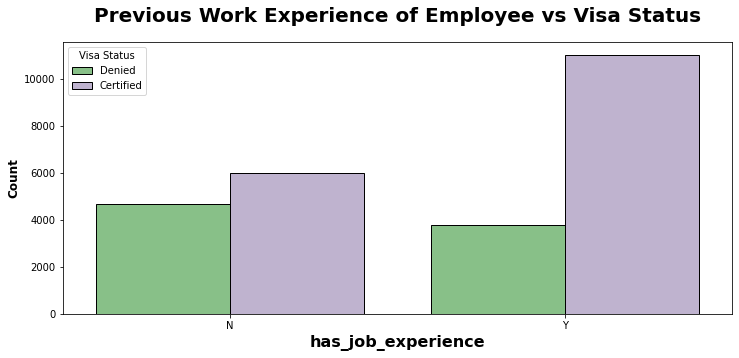

In [45]:
plt.subplots(figsize=(12,5))
sns.countplot(x="has_job_experience",hue="case_status", data=data, ec= "black",palette="Accent")
plt.title("Previous Work Experience of Employee vs Visa Status", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=12)
plt.xlabel("has_job_experience", weight="bold", fontsize=16)
plt.legend(title="Visa Status", fancybox=True)
plt.show()

- The majority of applicants with prior work experience (Y) are more likely to get visa certification. The denial count is significantly lower compared to those without experience.
- A larger proportion of applicants without job experience (N) face visa denials. While some still receive certification, the denial rate is relatively high.

#### requires_job_training vs case_status

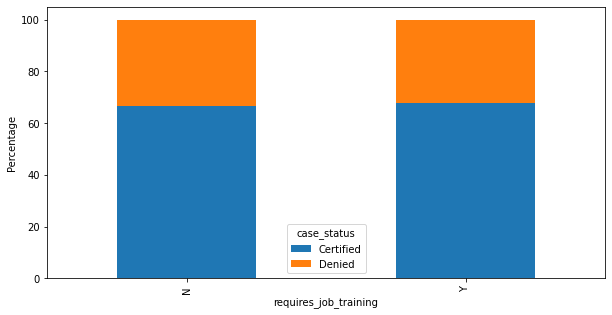

In [46]:
# Create a crosstab for Education & Loan
ct = pd.crosstab(data['requires_job_training'], data['case_status'], normalize='index') * 100

# Plot Stacked Bar Chart
ct.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("")
plt.ylabel("Percentage")
plt.show()

- Both categories (requires training = Y and N) have similar proportions of Certified and Denied cases.
- The Certified cases (blue) appear to dominate in both groups. The percentage of denials (orange section) remains fairly constant between the two groups.
- This suggests that requiring job training does not heavily impact the likelihood of visa approval.

#### region_of_employment vs case_status

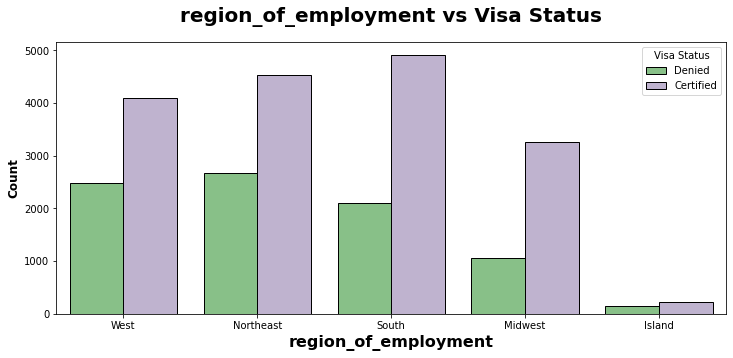

In [47]:
plt.subplots(figsize=(12,5))
sns.countplot(x="region_of_employment",hue="case_status", data=data, ec = "black",palette="Accent")
plt.title("region_of_employment vs Visa Status", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=12)
plt.xlabel("region_of_employment", weight="bold", fontsize=16)
plt.legend(title="Visa Status", fancybox=True)
plt.show()

- The South has the highest number of Certified visa applications, followed by the Northeast. The West and Midwest also have significant visa approvals.
- Denials are Highest in the Northeast and West.
- The Island category has the fewest applications overall, with both certifications and denials being minimal.

#### unit_of_wage vs case_status

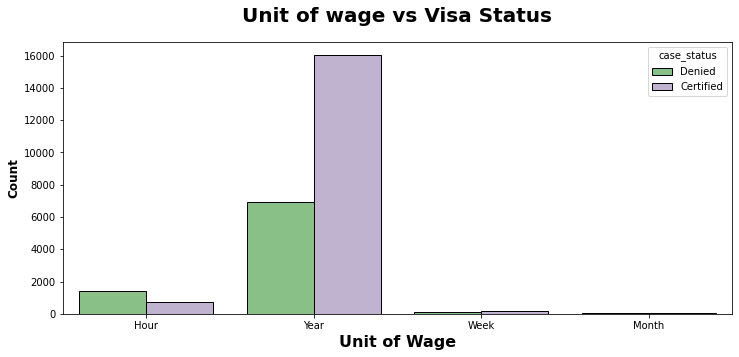

In [48]:
plt.subplots(figsize=(12,5))
sns.countplot(x="unit_of_wage",hue="case_status", data=data,ec='k', palette='Accent')
plt.title("Unit of wage vs Visa Status", weight="bold",fontsize=20, pad=20)
plt.xlabel("Unit of Wage", weight="bold", fontsize=16)
plt.ylabel("Count", weight="bold", fontsize=12)
plt.show()

- A large majority of visa applications are based on yearly wages. Certified applications significantly outnumber denied applications for annual salaries.
- Applications with hourly wages have higher denial rates compared to yearly wages. This suggests that jobs offering hourly wages might not meet the visa approval criteria as easily as salaried positions.
- Few applications use "Week" or "Month" as the wage unit. The small numbers suggest these are uncommon ways to report wages in visa applications.

#### full_time_position vs case_status

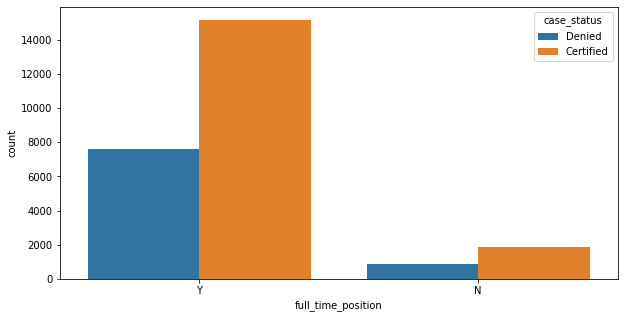

In [49]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Create a countplot to show loan acceptance by securities account holders
sns.countplot(x=data['full_time_position'], hue=data['case_status'])
plt.title("")

# Display the plot
plt.show()

- A majority of certified applications are for full-time positions. While some full-time applications are denied, the approval rate is significantly higher than denials.
- Far fewer applications are for part-time positions. The rate of approval seems to be similar to full-time positions.

#### no_of_employees vs case_status

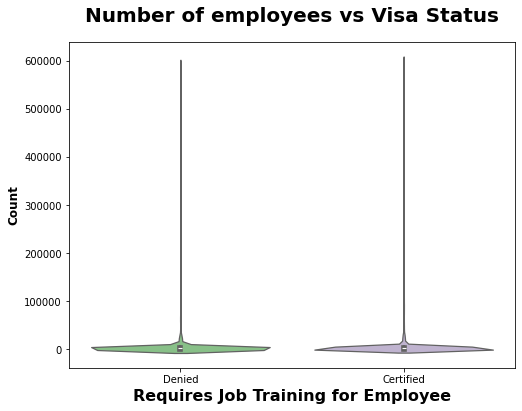

In [50]:
plt.subplots(figsize=(8,6))
sns.violinplot(x="case_status",y='no_of_employees', data=data, palette="Accent")
plt.title("Number of employees vs Visa Status", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=12)
plt.xlabel("Requires Job Training for Employee", weight="bold", fontsize=16)
plt.ylim()
plt.show()

- The shape of the distributions for both categories is quite similar, meaning that whether a company requires job training or not does not significantly impact the number of employees it has.
- There are companies with hundreds of thousands of employees, but they are rare. The extremely long vertical spread indicates that a small number of very large companies exist in both categories

#### yr_of_estab vs case_status

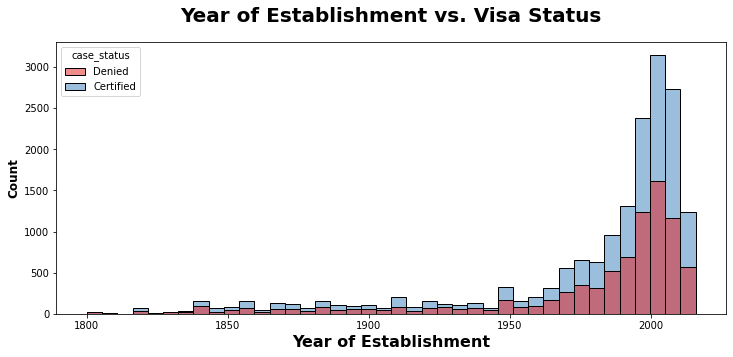

In [51]:
plt.subplots(figsize=(12,5))
sns.histplot(x="yr_of_estab", data=data, bins=40, hue='case_status', palette='Set1') # Changed palette
plt.title("Year of Establishment vs. Visa Status", weight="bold", fontsize=20, pad=20)
plt.xlabel("Year of Establishment", weight="bold", fontsize=16)
plt.ylabel("Count", weight="bold", fontsize=12) # Corrected y-axis label
plt.show()

- While both "Denied" and "Certified" applications increase for recent years, the "Certified" bars are consistently taller than the "Denied" bars. This suggests a higher rate of visa approval for companies established in recent years.
- The number of visa applications is very low for companies established before 1950

# Feature Engineering (Cont.)

- As we saw that 'requires_job_training' attribute had very less impact on classifying the applicant's visa status, we will drop that column.

In [52]:
data.drop('requires_job_training', inplace=True, axis=1)

- We will drop the 'prevailing_wage' attribute as we have added the 'annual_wage' column which will be more useful.

In [53]:
data.drop('prevailing_wage', inplace=True, axis=1)

- We will add a new column 'company_age' by subtracting the yr_of_estab column by the current year. This will be useful for modelling.

In [54]:
# importing date class from datetime module
from datetime import date

# creating the date object of today's date
todays_date = date.today()
current_year= todays_date.year

In [55]:
current_year

2025

In [56]:
# Subtract current year with year of estab to get company's age

data['company_age'] = current_year-data['yr_of_estab']

- Drop the 'yr_of_estab' column.

In [57]:
data.drop('yr_of_estab', inplace=True, axis=1)

- One-Hot Encode Nominal Categorical Columns

In [58]:
columns_to_onehot = ['continent', 'region_of_employment', 'unit_of_wage']
data = pd.get_dummies(data, columns=columns_to_onehot, drop_first=True)  # drop_first to avoid multicollinearity

In [59]:
data.head()

,education_of_employee,has_job_experience,no_of_employees,full_time_position,case_status,annual_wage,company_age,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year
0,High School,N,14513,Y,Denied,1231782.032,18,True,False,False,False,False,False,False,False,True,False,False,False
1,Master's,Y,2412,Y,Certified,83425.650,23,True,False,False,False,False,False,True,False,False,False,False,True
2,Bachelor's,N,44444,Y,Denied,122996.860,17,True,False,False,False,False,False,False,False,True,False,False,True
3,Bachelor's,N,98,Y,Denied,83434.030,128,True,False,False,False,False,False,False,False,True,False,False,True
4,Master's,Y,1082,Y,Certified,149907.390,20,False,False,False,False,False,False,False,True,False,False,False,True


- Convert only the one-hot encoded columns to integers

In [60]:
for col in data.columns:
    if col.startswith(tuple(columns_to_onehot)): #check if the column startswith one of the original one hot encoded columns
        data[col] = data[col].astype(int)


In [61]:
data.head()

,education_of_employee,has_job_experience,no_of_employees,full_time_position,case_status,annual_wage,company_age,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year
0,High School,N,14513,Y,Denied,1231782.032,18,1,0,0,0,0,0,0,0,1,0,0,0
1,Master's,Y,2412,Y,Certified,83425.650,23,1,0,0,0,0,0,1,0,0,0,0,1
2,Bachelor's,N,44444,Y,Denied,122996.860,17,1,0,0,0,0,0,0,0,1,0,0,1
3,Bachelor's,N,98,Y,Denied,83434.030,128,1,0,0,0,0,0,0,0,1,0,0,1
4,Master's,Y,1082,Y,Certified,149907.390,20,0,0,0,0,0,0,0,1,0,0,0,1


- Label Encode Binary Categorical Columns

In [62]:
binary_columns = ['has_job_experience', 'full_time_position', 'case_status']
for col in binary_columns:
    data[col] = data[col].map({'Y': 1, 'N': 0, 'Certified': 1, 'Denied': 0}) # Map 'Y' to 1, 'N' to 0; Certified to 1, Denied to 0

- Ordinal Encode 'education_of_employee'

In [63]:
education_mapping = {
    'High School': 1,
    'Bachelor\'s': 2,
    'Master\'s': 3,
    'Doctorate': 4
}
data['education_of_employee'] = data['education_of_employee'].map(education_mapping)

In [64]:
data.head()

,education_of_employee,has_job_experience,no_of_employees,full_time_position,case_status,annual_wage,company_age,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year
0,1,0,14513,1,0,1231782.032,18,1,0,0,0,0,0,0,0,1,0,0,0
1,3,1,2412,1,1,83425.650,23,1,0,0,0,0,0,1,0,0,0,0,1
2,2,0,44444,1,0,122996.860,17,1,0,0,0,0,0,0,0,1,0,0,1
3,2,0,98,1,0,83434.030,128,1,0,0,0,0,0,0,0,1,0,0,1
4,3,1,1082,1,1,149907.390,20,0,0,0,0,0,0,0,1,0,0,0,1


## Data Preparation and Modelling

Split the data in train, test and validation sets.

In [65]:
# Separating the dependent and independent variables
X = data.drop('case_status', axis=1)
y = data['case_status']

# 1. Split into train and temp (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,                     # 30% of data for temp (test + validation)
    stratify=y,                        # Stratify to maintain class balance
    random_state=42                    # For reproducibility
)

# 2. Split temp into test and validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,                     # 50% of temp for test, 50% for validation
    stratify=y_temp,                   # Stratify to maintain class balance
    random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)

(17836, 18) (3822, 18) (3822, 18)


Define a function to compute different metrics to check performance of a classification model built using sklearn

In [66]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = round(accuracy_score(target, pred), 3)  # to compute Accuracy
    recall = round(recall_score(target, pred), 3)  # to compute Recall
    precision = round(precision_score(target, pred), 3)  # to compute Precision
    f1 = round(f1_score(target, pred), 3)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

Define a function to plot confusion matrix

In [67]:
def plot_confusion_matrix(model, predictors, target):
    """
    To plot the confusion_matrix with peracentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    # Predict the target values using the provided model and predictors
    y_pred = model.predict(predictors)

    # Compute the confusion matrix comparing the true target values with the predicted values
    cm = confusion_matrix(target, y_pred)

    # Create labels for each cell in the confusion matrix with both count and percentage
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)    # reshaping to a matrix

    # Set the figure size for the plot
    plt.figure(figsize=(6, 4))

    # Plot the confusion matrix as a heatmap with the labels
    sns.heatmap(cm, annot=labels, fmt="")

    # Add a label to the y-axis
    plt.ylabel("True label")

    # Add a label to the x-axis
    plt.xlabel("Predicted label")

Train a decision tree model on the original dataset without specifying any hyperparameters and check the importance of the features.

In [68]:
dt1 = DecisionTreeClassifier(random_state=42)
dt1.fit(X_train, y_train)

feature_importance_df = pd.DataFrame(dt1.feature_importances_, index=X.columns, columns=['Importance'])
print(feature_importance_df)

                                Importance
education_of_employee             0.110657
has_job_experience                0.048165
no_of_employees                   0.251140
full_time_position                0.016377
annual_wage                       0.260745
company_age                       0.169152
continent_Asia                    0.010127
continent_Europe                  0.019386
continent_North America           0.012552
continent_Oceania                 0.004219
continent_South America           0.005998
region_of_employment_Midwest      0.015767
region_of_employment_Northeast    0.013905
region_of_employment_South        0.014843
region_of_employment_West         0.011370
unit_of_wage_Month                0.001767
unit_of_wage_Week                 0.000641
unit_of_wage_Year                 0.033188


- annual_wage (0.26) and no_of_employees (0.25) are the most influential in determining visa status or a related outcome.
- education_of_employee (0.11) and company_age (0.17) also play crucial roles.
- has_job_experience (0.048) and continent_Europe (0.019) have some effect but are less dominant.

Evaluate the decision tree model 1 on train and validation data.

Performance of the decision tree model 1 on training set:

    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0 

Performance of the decision tree model 1 on validation set:

    Accuracy  Recall  Precision     F1
0     0.669   0.763      0.746  0.755


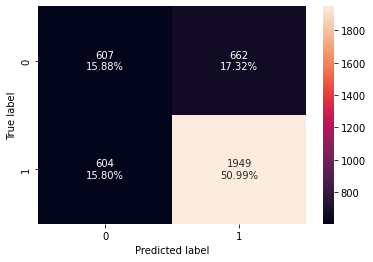

In [131]:
# Calculate and display model performance on training and validation sets.
dt1_train_perf = model_performance_classification(dt1, X_train, y_train)
dt1_val_perf = model_performance_classification(dt1, X_val, y_val)

# Display the performance metrics.
print('Performance of the decision tree model 1 on training set:\n\n', dt1_train_perf, '\n')
print('Performance of the decision tree model 1 on validation set:\n\n', dt1_val_perf)

# Plot confusion matrix for model evaluation.
plot_confusion_matrix(dt1, X_val, y_val)

- The model is overfitting as it is not performing well on the validation data.

Train the random forest model on the original dataset and check the performance on the train and validation data.

Performance of the random forest model 1 on training set:

    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0 

Performance of the random forest model 1 on validation set:

    Accuracy  Recall  Precision     F1
0     0.726   0.841       0.77  0.804


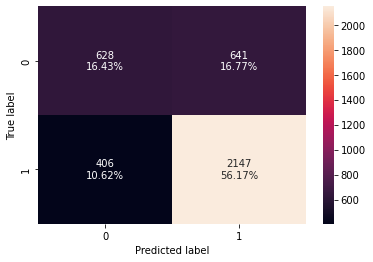

In [117]:
# Train a Random Forest Classifier (rfc1) and evaluate its performance.
rfc1 = RandomForestClassifier(random_state=42)
rfc1.fit(X_train, y_train)

# Calculate performance metrics for the training and validation sets.
rfc1_train_perf = model_performance_classification(rfc1, X_train, y_train)
rfc1_val_perf = model_performance_classification(rfc1, X_val, y_val)

# Display the performance metrics.
print('Performance of the random forest model 1 on training set:\n\n', rfc1_train_perf, '\n')
print('Performance of the random forest model 1 on validation set:\n\n', rfc1_val_perf)

# Plot the confusion matrix for the validation set.
plot_confusion_matrix(rfc1, X_val, y_val)

- The huge performance gap (100% training vs. 72.6% validation) suggests the model does not generalize well.

Train a Bagging classifier on the original dataset and evaluate the performance on train and validation data.**bold text**

Performance of the bagging classifier model 1 on training set:

    Accuracy  Recall  Precision     F1
0     0.984   0.985      0.992  0.988 

Performance of the bagging classifier model 1 on validation set:

    Accuracy  Recall  Precision     F1
0     0.701    0.78      0.774  0.777


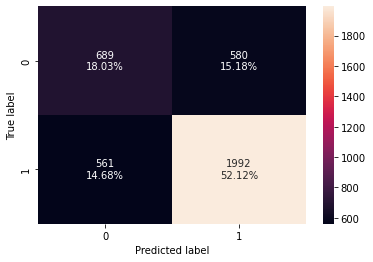

In [71]:
# Train a Bagging Classifier (bagging1) and evaluate its performance.
bagging1 = BaggingClassifier(random_state=42)
bagging1.fit(X_train, y_train)

# Calculate performance metrics for the training and validation sets.
bagging1_train_perf = model_performance_classification(bagging1, X_train, y_train)
bagging1_val_perf = model_performance_classification(bagging1, X_val, y_val)

# Display the performance metrics.
print('Performance of the bagging classifier model 1 on training set:\n\n', bagging1_train_perf, '\n')
print('Performance of the bagging classifier model 1 on validation set:\n\n', bagging1_val_perf)

# Plot the confusion matrix for the validation set.
plot_confusion_matrix(bagging1, X_val, y_val)

- The bagging classifier is also overfitting as it is not generalizing well.

Create oversampled data using SMOTE to balance the classes in the output variable.

In [72]:
# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to training data
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# Print class distribution before and after oversampling
print("Before Oversampling:\n", y_train.value_counts())
print("\nAfter Oversampling:\n", pd.Series(y_train_over).value_counts())

Before Oversampling:
 case_status
1    11913
0     5923
Name: count, dtype: int64

After Oversampling:
 case_status
0    11913
1    11913
Name: count, dtype: int64


Train a decision tree model on the oversampled data and evaluate the performance on the train and validation data.

In [129]:
# Train a Decision Tree Classifier (dt2) on oversampled data and evaluate performance.
dt2 = DecisionTreeClassifier(random_state=42)
dt2.fit(X_train_over, y_train_over)

# Calculate performance metrics on oversampled training data and original validation data.
dt2_train_perf = model_performance_classification(dt2, X_train_over, y_train_over)
dt2_val_perf = model_performance_classification(dt2, X_val, y_val)

# Display performance metrics for training and validation sets.
print('Performance of the decision tree model 2 on training set:\n\n', dt2_train_perf, '\n')
print('Performance of the decision tree model 2 on validation set:\n\n', dt2_val_perf)

Performance of the decision tree model 2 on training set:

    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0 

Performance of the decision tree model 2 on validation set:

    Accuracy  Recall  Precision     F1
0     0.662   0.744      0.748  0.746


Train a random forest classifier on the oversampled data and evaluate the performance on the train and validation data.

In [122]:
# Train a Random Forest Classifier (rfc2) on oversampled data and evaluate performance.
rfc2 = RandomForestClassifier(random_state=42)
rfc2.fit(X_train_over, y_train_over)

# Calculate performance metrics on oversampled training data and original validation data.
rfc2_train_perf = model_performance_classification(rfc2, X_train_over, y_train_over)
rfc2_val_perf = model_performance_classification(rfc2, X_val, y_val)

# Display performance metrics for training and validation sets.
print('Performance of the random forest model 2 on training set:\n\n', rfc2_train_perf, '\n')
print('Performance of the random forest model 2 on validation set:\n\n', rfc2_val_perf)

Performance of the random forest model 2 on training set:

    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0 

Performance of the random forest model 2 on validation set:

    Accuracy  Recall  Precision     F1
0     0.717   0.808      0.777  0.792


Train a bagging classifier model on the oversampled data and evaluate the performance on the train and validation data.

In [128]:
# Train a Bagging Classifier (bagging2) on oversampled data and evaluate performance.
bagging2 = BaggingClassifier(random_state=42)
bagging2.fit(X_train_over, y_train_over)

# Calculate performance metrics on oversampled training data and original validation data.
bagging2_train_perf = model_performance_classification(bagging2, X_train_over, y_train_over)
bagging2_val_perf = model_performance_classification(bagging2, X_val, y_val)

# Display performance metrics for training and validation sets.
print('Performance of the bagging classifier model 2 on training set:\n\n', bagging2_train_perf, '\n')
print('Performance of the bagging classifier model 2 on validation set:\n\n', bagging2_val_perf)

Performance of the bagging classifier model 2 on training set:

    Accuracy  Recall  Precision     F1
0     0.985   0.978      0.992  0.985 

Performance of the bagging classifier model 2 on validation set:

    Accuracy  Recall  Precision     F1
0     0.688   0.756      0.772  0.764


- All the three models have overfit when trained on the oversampled data as well

Create an undersampled data using RandomUnderSampler to balance the classes in the output variable.

In [76]:
# Define the undersampler
undersampler = RandomUnderSampler(sampling_strategy=1, random_state=42)

# Apply undersampling
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Print class distribution before and after oversampling
print("Before Undersampling:\n", y_train.value_counts())
print("\nAfter Undersampling:\n", pd.Series(y_train_under).value_counts())

Before Undersampling:
 case_status
1    11913
0     5923
Name: count, dtype: int64

After Undersampling:
 case_status
0    5923
1    5923
Name: count, dtype: int64


Train a decision tree model on the undersampled data and evaluate the performance on the train and validation data.

In [125]:
# Train a Decision Tree Classifier (dt3) on undersampled data and evaluate performance.
dt3 = DecisionTreeClassifier(random_state=42)
dt3.fit(X_train_under, y_train_under)

# Calculate performance metrics on undersampled training data and original validation data.
dt3_train_perf = model_performance_classification(dt3, X_train_under, y_train_under)
dt3_val_perf = model_performance_classification(dt3, X_val, y_val)

# Display performance metrics for training and validation sets.
print('Performance of the decision tree model 3 on training set:\n\n', dt3_train_perf, '\n')
print('Performance of the decision tree model 3 on validation set:\n\n', dt3_val_perf)

Performance of the decision tree model 3 on training set:

    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0 

Performance of the decision tree model 3 on validation set:

    Accuracy  Recall  Precision     F1
0     0.626   0.636      0.765  0.694


Train a random forest classifier model on the undersampled data and evaluate the performance on the train and validation data.

In [126]:
# Train a Random Forest Classifier (rfc3) on undersampled data and evaluate performance.
rfc3 = RandomForestClassifier(random_state=42)
rfc3.fit(X_train_under, y_train_under)

# Calculate performance metrics on undersampled training data and original validation data.
rfc3_train_perf = model_performance_classification(rfc3, X_train_under, y_train_under)
rfc3_val_perf = model_performance_classification(rfc3, X_val, y_val)

# Display performance metrics for training and validation sets.
print('Performance of the random forest model 3 on training set:\n\n', rfc3_train_perf, '\n')
print('Performance of the random forest model 3 on validation set:\n\n', rfc3_val_perf)

Performance of the random forest model 3 on training set:

    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0 

Performance of the random forest model 3 on validation set:

    Accuracy  Recall  Precision     F1
0     0.679   0.678       0.81  0.739


Train a bagging classifier model on the undersampled data and evaluate the performance on the train and validation data.




In [127]:
# Train a Bagging Classifier (bagging3) on undersampled data and evaluate performance.
bagging3 = BaggingClassifier(random_state=42)
bagging3.fit(X_train_under, y_train_under)

# Calculate performance metrics on undersampled training data and original validation data.
bagging3_train_perf = model_performance_classification(bagging3, X_train_under, y_train_under)
bagging3_val_perf = model_performance_classification(bagging3, X_val, y_val)

# Display performance metrics for training and validation sets.
print('Performance of the bagging classifier model 3 on training set:\n\n', bagging3_train_perf, '\n')
print('Performance of the bagging classifier model 3 on validation set:\n\n', bagging3_val_perf)

Performance of the bagging classifier model 3 on training set:

    Accuracy  Recall  Precision     F1
0     0.978   0.967      0.989  0.978 

Performance of the bagging classifier model 3 on validation set:

    Accuracy  Recall  Precision     F1
0     0.644   0.618      0.804  0.699


- The decision tree classifier from the original and oversampled data has performed well.
- The random forest models from the original dataset and the oversampled dataset have performed equally well on Accuracy(~72%) and F1 score(80%).
- The Bagging classifiers from the original dataset and oversampled has performed equally on F1 score.
- We will be using the oversampled dataset for further improving our models.

## Hyperparameter tuning

#### Tuning the decision tree model with Grid Search CV and fitting it on the oversampled data.

In [80]:
dt_tuned1 = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [5, 6, 7, 8, 10, 12, None],          # Tree depth
    'max_features': [None, 'sqrt', 'log2', 0.5],
    'min_samples_split': [7, 10, 11, 12, 13],        # Min samples to split a node
    'min_samples_leaf': [4, 5, 6, 7, 8, 10],          # Min samples per leaf node
}

# Set up Grid Search with Recall as the scoring metric
grid_search = GridSearchCV(
    estimator=dt_tuned1,
    param_grid=param_grid,
    scoring='recall',  # Optimize for recall
    cv=5,              # 5-fold cross-validation
    n_jobs=-1,         # Use all available CPU cores
    verbose=2          # Show number of fits
)

# Fit the grid search on training data
grid_search.fit(X_train_over, y_train_over)

# Print the best parameters and best recall score
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# Get the best model
dt_tuned_grid = grid_search.best_estimator_

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
Best Parameters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 12}
Best Recall Score: 0.8310265161885212


In [81]:
print('Performance of the tuned decision tree model on training set:\n\n', model_performance_classification(dt_tuned_grid, X_train_over, y_train_over), '\n')

print('Performance of the tuned decision tree model on validation set:\n\n', model_performance_classification(dt_tuned_grid, X_val, y_val))


Performance of the tuned decision tree model on training set:

    Accuracy  Recall  Precision     F1
0     0.794   0.838      0.771  0.803 

Performance of the tuned decision tree model on validation set:

    Accuracy  Recall  Precision     F1
0     0.734    0.83      0.784  0.806


- Thought the accuracy of the tuned model decreases for validation data when compared to the training data, the model has good recall and precision scores.

#### Tuning the decision tree model with Random Search CV and fitting it on the oversampled data.

In [82]:
dt_tuned2 = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter search space
param_grid = {
    'max_depth': np.arange(3, 20, 2),          # Tree depth
    'max_features': [None, 'sqrt', 'log2', 0.5],     # Feature selection
    'min_samples_split': np.arange(5, 25, 2),        # Min samples to split a node
    'min_samples_leaf': np.arange(5, 25, 2),         # Min samples per leaf node
}

# Set up Randomized Search with Recall as the scoring metric
random_search = RandomizedSearchCV(
    estimator=dt_tuned2,               # Decision Tree model
    param_distributions=param_grid,  # Hyperparameter distribution
    n_iter=20,                   # Number of random combinations to try
    scoring='recall',             # Optimize for recall
    cv=5,                         # 5-fold cross-validation
    n_jobs=-1,                    # Use all available CPU cores
    verbose=2,                     # Show number of fits
    random_state=42               # For reproducibility
)

# Fit the random search on training data
random_search.fit(X_train_over, y_train_over)

# Print the best parameters and best recall score
print("Best Parameters:", random_search.best_params_)
print("Best Recall Score:", random_search.best_score_)

# Get the best model
dt_tuned_random = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'min_samples_split': np.int64(5), 'min_samples_leaf': np.int64(17), 'max_features': None, 'max_depth': np.int64(7)}
Best Recall Score: 0.8309433282842751


In [83]:
print('Performance of the tuned decision tree model on training set:\n\n', model_performance_classification(dt_tuned_random, X_train_over, y_train_over), '\n')

print('Performance of the tuned decision tree model on validation set:\n\n', model_performance_classification(dt_tuned_random, X_val, y_val))

Performance of the tuned decision tree model on training set:

    Accuracy  Recall  Precision     F1
0     0.793   0.836       0.77  0.801 

Performance of the tuned decision tree model on validation set:

    Accuracy  Recall  Precision     F1
0     0.731   0.828      0.782  0.804


- The model tuned with random search cv is as good as the model tuned with grid search cv and is performing well for both accuracy and F1.

- Since Grid Search takes long hours to train, we will only be using Random Search CV to train some models.

#### Tuning the random forest classifier model with Random Search CV and fitting it on the oversampled data.

In [84]:
rfc_tuned2 =  RandomForestClassifier(random_state=42)

# Define the hyperparameter search space
param_grid = {"n_estimators": [200,250, 300],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
    "max_depth":np.arange(3,14,2),
    "class_weight" : ['balanced', 'balanced_subsample'],
    "min_impurity_decrease":[0.001, 0.002, 0.003]
}

# Set up Randomized Search with Recall as the scoring metric
random_search = RandomizedSearchCV(
    estimator=rfc_tuned2,               # Decision Tree model
    param_distributions=param_grid,  # Hyperparameter distribution
    n_iter=30,                   # Number of random combinations to try
    scoring='recall',             # Optimize for recall
    cv=5,                         # 5-fold cross-validation
    n_jobs=-1,                    # Use all available CPU cores
    verbose=2,                     # Show number of fits
)

# Fit the random search on training data
random_search.fit(X_train_over, y_train_over)

# Print the best parameters and best recall score
print("Best Parameters:", random_search.best_params_)
print("Best Recall Score:", random_search.best_score_)

# Get the best model
rfc_tuned_random = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 300, 'min_samples_leaf': np.int64(5), 'min_impurity_decrease': 0.001, 'max_samples': np.float64(0.3), 'max_features': np.float64(0.4000000000000001), 'max_depth': np.int64(13), 'class_weight': 'balanced_subsample'}
Best Recall Score: 0.8252343689716517


In [85]:
print('Performance of the tuned random forest classifier model on training set:\n\n', model_performance_classification(rfc_tuned_random, X_train_over, y_train_over), '\n')

print('Performance of the tuned random forest classifier model on validation set:\n\n', model_performance_classification(rfc_tuned_random, X_val, y_val))

Performance of the tuned random forest classifier model on training set:

    Accuracy  Recall  Precision     F1
0     0.786   0.814       0.77  0.791 

Performance of the tuned random forest classifier model on validation set:

    Accuracy  Recall  Precision     F1
0     0.728   0.811      0.788  0.799


- The tuned random forest model is not overfitting on the validation set. It's accuracy is decent and the F1 score is as good as that on the training  data.

#### Tuning the bagging classifier model with Grid Search CV and fitting it on the oversampled data.

In [86]:
bagging_tuned1 = BaggingClassifier(random_state=42)

# Define the hyperparameter search space
param_grid = {
    "n_estimators": [10, 50, 100, 200],  # Number of base estimators
    "max_samples": [0.5, 0.7, 1.0],      # Fraction of dataset per estimator
    "max_features": [0.5, 0.7, 1.0],     # Fraction of features per estimator
    "bootstrap": [True, False],          # Bootstrap sampling
    "bootstrap_features": [True, False], # Bootstrap feature sampling
}

# Set up Randomized Search with Recall as the scoring metric
grid_search = GridSearchCV(
    estimator=bagging_tuned1,               # Decision Tree model
    param_grid=param_grid,  # Hyperparameter distribution
    scoring='recall',             # Optimize for recall
    cv=5,                         # 5-fold cross-validation
    n_jobs=-1,                    # Use all available CPU cores
    verbose=2,                     # Show number of fits
)

# Fit the random search on training data
grid_search.fit(X_train_over, y_train_over)

# Print the best parameters and best recall score
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# Get the best model
bagging_tuned_random = grid_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 200}
Best Recall Score: 0.8220465915685307


In [87]:
print('Performance of the tuned bagging classifier model on training set:\n\n', model_performance_classification(bagging_tuned_random, X_train_over, y_train_over), '\n')

print('Performance of the tuned bagging classifier model on validation set:\n\n', model_performance_classification(bagging_tuned_random, X_val, y_val))

Performance of the tuned bagging classifier model on training set:

    Accuracy  Recall  Precision   F1
0       1.0     1.0      0.999  1.0 

Performance of the tuned bagging classifier model on validation set:

    Accuracy  Recall  Precision     F1
0     0.724   0.829      0.774  0.801


#### Tuning the bagging classifier model with Random Search CV and fitting it on the oversampled data.

In [136]:
bagging_tuned2 = BaggingClassifier(random_state=42)

# Define the hyperparameter search space
param_grid = {
    "n_estimators": [10, 50, 100, 150, 200],  # Number of base estimators
    "max_samples": [0.4, 0.5, 0.7, 1.0],      # Fraction of dataset per estimator
    "max_features": [0.5, 0.7, 1.0],     # Fraction of features per estimator
    "bootstrap": [True, False],          # Bootstrap sampling
    "bootstrap_features": [True, False], # Bootstrap feature sampling
}

# Set up Randomized Search with Recall as the scoring metric
random_search = RandomizedSearchCV(
    estimator=bagging_tuned2,               # Decision Tree model
    param_distributions=param_grid,  # Hyperparameter distribution
    n_iter=30,                   # Number of random combinations to try
    scoring='recall',             # Optimize for recall
    cv=5,                         # 5-fold cross-validation
    n_jobs=-1,                    # Use all available CPU cores
    verbose=2,                     # Show number of fits
    random_state=42               # For reproducibility
)

# Fit the random search on training data
random_search.fit(X_train_over, y_train_over)

# Print the best parameters and best recall score
print("Best Parameters:", random_search.best_params_)
print("Best Recall Score:", random_search.best_score_)

# Get the best model
bagging_tuned_random = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 200, 'max_samples': 0.4, 'max_features': 0.7, 'bootstrap_features': True, 'bootstrap': True}
Best Recall Score: 0.8199477970356073


In [89]:
print('Performance of the tuned bagging classifier model on training set:\n\n', model_performance_classification(bagging_tuned_random, X_train_over, y_train_over), '\n')

print('Performance of the tuned bagging classifier model on validation set:\n\n', model_performance_classification(bagging_tuned_random, X_val, y_val))

Performance of the tuned bagging classifier model on training set:

    Accuracy  Recall  Precision     F1
0     0.988   0.993      0.983  0.988 

Performance of the tuned bagging classifier model on validation set:

    Accuracy  Recall  Precision     F1
0     0.726    0.83      0.775  0.802


Train the Adaboost classifier on the original, oversampled and undersampled data and evaluate the performance on the train and valiation data.





- Even the tuned bagging classifier model is overfitting on the validation data.

In [90]:
# Train an AdaBoost Classifier (adaboost1) and evaluate its performance.
adaboost1 = AdaBoostClassifier(random_state=42)
adaboost1.fit(X_train, y_train)

# Calculate performance metrics for the training and validation sets.
adaboost1_train_perf = model_performance_classification(adaboost1, X_train, y_train)
adaboost1_val_perf = model_performance_classification(adaboost1, X_val, y_val)

# Display the performance metrics.
print('Performance of the adaboost1 model on training set:\n\n', adaboost1_train_perf, '\n')
print('Performance of the adaboost1 model on validation set:\n\n', adaboost1_val_perf, '\n')

Performance of the adaboost1 model on training set:

    Accuracy  Recall  Precision     F1
0     0.737   0.885       0.76  0.818 

Performance of the adaboost1 model on validation set:

    Accuracy  Recall  Precision     F1
0     0.727   0.883      0.752  0.812 



In [91]:
# Train an AdaBoost Classifier (adaboost2) on oversampled data and evaluate its performance.
adaboost2 = AdaBoostClassifier(random_state=42)
adaboost2.fit(X_train_over, y_train_over)

# Calculate performance metrics for the oversampled training data and original validation data.
adaboost2_train_perf = model_performance_classification(adaboost2, X_train_over, y_train_over)
adaboost2_val_perf = model_performance_classification(adaboost2, X_val, y_val)

# Display the performance metrics.
print('Performance of the adaboost2 model on training set:\n\n', adaboost2_train_perf, '\n')
print('Performance of the adaboost2 model on validation set:\n\n', adaboost2_val_perf, '\n')

Performance of the adaboost2 model on training set:

    Accuracy  Recall  Precision     F1
0     0.774   0.782       0.77  0.776 

Performance of the adaboost2 model on validation set:

    Accuracy  Recall  Precision    F1
0     0.693   0.769      0.772  0.77 



In [92]:
# Train an AdaBoost Classifier (adaboost3) on undersampled data and evaluate its performance.
adaboost3 = AdaBoostClassifier(random_state=43)  # Note: random_state is 43 here
adaboost3.fit(X_train_under, y_train_under)

# Calculate performance metrics for the undersampled training data and original validation data.
adaboost3_train_perf = model_performance_classification(adaboost3, X_train_under, y_train_under)
adaboost3_val_perf = model_performance_classification(adaboost3, X_val, y_val)

# Display the performance metrics.
print('Performance of the adaboost3 model on training set:\n\n', adaboost3_train_perf, '\n')
print('Performance of the adaboost3 model on validation set:\n\n', adaboost3_val_perf, '\n')

Performance of the adaboost3 model on training set:

    Accuracy  Recall  Precision     F1
0     0.692   0.712      0.684  0.698 

Performance of the adaboost3 model on validation set:

    Accuracy  Recall  Precision     F1
0      0.69   0.709      0.803  0.753 



- The adaboost model has done well on the original data with an accuracy of 73% and a F1-score of 82%. So, we will use the original data further.

#### Tuning the Adaboost classifier using Random Search CV and fitting it with the original data.

In [98]:
adaboost_tuned1 = AdaBoostClassifier(random_state=42)

# Grid of parameters to choose from
param_grid = {
    #Let's try different max_depth for base_estimator
    "estimator":[DecisionTreeClassifier(max_depth=1, random_state=1),DecisionTreeClassifier(max_depth=2, random_state=1),DecisionTreeClassifier(max_depth=3, random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1),
}

# Run the grid search
random_search = RandomizedSearchCV(adaboost_tuned1, param_distributions=param_grid, n_iter=30, scoring='recall',cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search = random_search.fit(X_train, y_train)

# Print the best parameters and best recall score
print("Best Parameters:", random_search.best_params_)
print("Best Recall Score:", random_search.best_score_)

# Get the best model
adaboost_tuned_random = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': np.int64(10), 'learning_rate': np.float64(0.8), 'estimator': DecisionTreeClassifier(max_depth=1, random_state=1)}
Best Recall Score: 0.9101004068491022


In [102]:
print('Performance of the tuned adaboost classifier model on training set:\n\n', model_performance_classification(adaboost_tuned_random, X_train, y_train), '\n')

print('Performance of the tuned adaboost classifier model on validation set:\n\n', model_performance_classification(adaboost_tuned_random, X_val, y_val))

Performance of the tuned adaboost classifier model on training set:

    Accuracy  Recall  Precision     F1
0     0.729   0.905      0.745  0.817 

Performance of the tuned adaboost classifier model on validation set:

    Accuracy  Recall  Precision     F1
0     0.724   0.906       0.74  0.814


- The tuned Adaboost model is not overfitting the validation data with an accuracy of 73% and F1-score of 82% on both the training and validation data.

Train the Gradient boosting classifier on the original, oversampled and undersampled data and evaluate the performance on the train and valiation data.

In [103]:
# Train a Gradient Boosting Classifier (gbc1) and evaluate its performance.
gbc1 = GradientBoostingClassifier(random_state=42)
gbc1.fit(X_train, y_train)

# Calculate performance metrics for the training and validation sets.
gbc1_train_perf = model_performance_classification(gbc1, X_train, y_train)
gbc1_val_perf = model_performance_classification(gbc1, X_val, y_val)

# Display the performance metrics.
print('Performance of the Gradient Boosting model 1 on training set:\n\n', gbc1_train_perf, '\n')
print('Performance of the Gradient Boosting model 1 on validation set:\n\n', gbc1_val_perf, '\n')

Performance of the Gradient Boosting model 1 on training set:

    Accuracy  Recall  Precision     F1
0     0.758   0.875      0.786  0.828 

Performance of the Gradient Boosting model 1 on validation set:

    Accuracy  Recall  Precision     F1
0     0.744   0.868      0.775  0.819 



In [104]:
# Train a Gradient Boosting Classifier (gbc2) on oversampled data and evaluate performance.
gbc2 = GradientBoostingClassifier(random_state=42)
gbc2.fit(X_train_over, y_train_over)

# Calculate performance metrics for the oversampled training data and original validation data.
gbc2_train_perf = model_performance_classification(gbc2, X_train_over, y_train_over)
gbc2_val_perf = model_performance_classification(gbc2, X_val, y_val)

# Display the performance metrics.
print('Performance of the Gradient Boosting model 2 on training set:\n\n', gbc2_train_perf, '\n')
print('Performance of the Gradient Boosting model 2 on validation set:\n\n', gbc2_val_perf, '\n')

Performance of the Gradient Boosting model 2 on training set:

    Accuracy  Recall  Precision    F1
0     0.802   0.845      0.778  0.81 

Performance of the Gradient Boosting model 2 on validation set:

    Accuracy  Recall  Precision     F1
0     0.735   0.835      0.783  0.808 



In [139]:
# Train a Gradient Boosting Classifier (gbc3) on undersampled data and evaluate performance.
gbc3 = GradientBoostingClassifier(random_state=42)
gbc3.fit(X_train_under, y_train_under)

# Calculate performance metrics for the undersampled training data and original validation data.
gbc3_train_perf = model_performance_classification(gbc3, X_train_under, y_train_under)
gbc3_val_perf = model_performance_classification(gbc3, X_val, y_val)

# Display the performance metrics.
print('Performance of the Gradient Boosting model 3 on training set:\n\n', gbc3_train_perf, '\n')
print('Performance of the Gradient Boosting model 3 on validation set:\n\n', gbc3_val_perf, '\n')

Performance of the Gradient Boosting model 3 on training set:

    Accuracy  Recall  Precision     F1
0      0.72   0.731      0.715  0.723 

Performance of the Gradient Boosting model 3 on validation set:

    Accuracy  Recall  Precision    F1
0      0.71   0.725       0.82  0.77 



- The gradient boosting classifier has performed apprximately equally on the original and the oversampled data. We will use the original data for further building the model.

#### Tuning the Gradient Boosting classifier using Random Search CV and fitting it with the original data.

In [137]:
gbc_tuned1 = GradientBoostingClassifier(random_state=42)

# Grid of parameters to choose from
param_grid = {
    'n_estimators': [100, 150, 300, 500],  # Number of boosting stages
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],  # Shrinks contribution of each tree
    'max_depth': [3, 4, 5, 7],  # Depth of individual trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 3, 5, 7],  # Minimum samples required at a leaf node
    'subsample': [0.5, 0.6, 0.8, 1.0],  # Fraction of samples used for training each tree
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider for best split
}

# Run the grid search
random_search = RandomizedSearchCV(gbc_tuned1, param_distributions=param_grid, scoring='recall',cv=5, n_iter=40, n_jobs=-1, verbose=2)
random_search = random_search.fit(X_train, y_train)

# Print the best parameters and best recall score
print("Best Parameters:", random_search.best_params_)
print("Best Recall Score:", random_search.best_score_)

# Get the best model
gbc_tuned_random = random_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.01}
Best Recall Score: 0.9486273291115737


In [138]:
print('Performance of the tuned Gradient boost model on training set:\n\n', model_performance_classification(gbc_tuned_random, X_train, y_train), '\n')

print('Performance of the tuned Gradient boost model on validation set:\n\n', model_performance_classification(gbc_tuned_random, X_val, y_val))

Performance of the tuned Gradient boost model on training set:

    Accuracy  Recall  Precision     F1
0     0.744   0.967      0.735  0.835 

Performance of the tuned Gradient boost model on validation set:

    Accuracy  Recall  Precision    F1
0     0.719   0.957      0.717  0.82


- Almost all the tuned models have an accuracy close to 72% and an F1 score close to 80%. We will evaluate the top models on the test data and look at the important features of some models.

### Important Features of the Top Models


In [149]:
model_performance_classification(rfc_tuned_random, X_test, y_test)

,Accuracy,Recall,Precision,F1
0,0.724,0.803,0.788,0.795


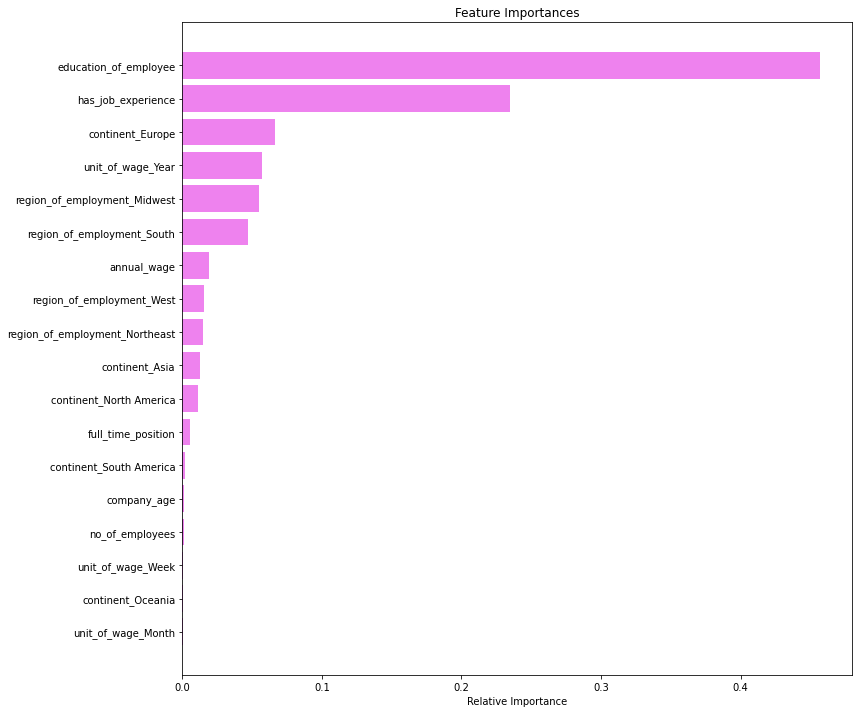

In [146]:
# Features of the tuned random forest model
feature_names = X_train.columns
importances = rfc_tuned_random.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [150]:
model_performance_classification(gbc_tuned_random, X_test, y_test)

,Accuracy,Recall,Precision,F1
0,0.721,0.948,0.721,0.819


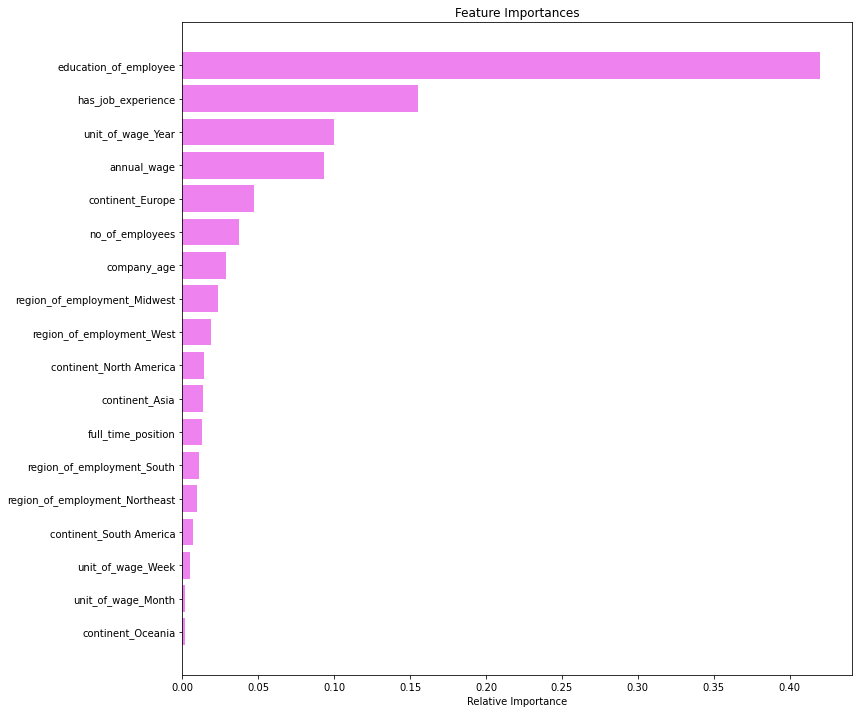

In [147]:
# Features of the tuned gradient boosting classifier model
feature_names = X_train.columns
importances = gbc_tuned_random.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- Both the tuned random forest model and the gradient boost classifier model are performing well on the production(test) data. The models are not overfitting and are generalizing well.

## Conclusion and Business Recommendataions

- The distribution for no_of_employees and annual_wage is highly righ-skewed, indicating that there are few companies which employee many number of people and few companies which are paying much greater than the average.
- Most of the applications are from Asia.
- Some of the key variables that are deemed important for prediction as highlighted by the top predictive models are: Education of Employee,
Unit of Wage, Prior job experience, Continent of origin, Region of Employment.
- An employee with only high school degree has a nearly 65% chance of visa rejection. An employee with a doctorate degree has very high chance of visa approval while one with masters degree has nearly 80% chance of visa approval.
- An employee with prior job experience has a 75% chance of visa approval which drops down to only 50%-60% chance of approval without prior job experience.
- Employees earning an annual salary have a 70% chance of visa approval. Employees paid on a hourly basis have a 65% chance of visa rejection.
- An employee coming from Europe has a good chance of visa approval.
- A candidate seeking a job in the Midwestern US has a 75% chance of visa approval. A candidate seeking a job in the Southern US has a 70% chance of visa approval.
- Based on the above attributes, a suitable candidate profile can be constructed and Easy Visa can recommend a candiate the likelihood of either visa acceptance or visa denial.
- For example, a doctorate holder from Europe with prior job experience and seeking a job with annual salary in the midwest may be a ideal candidate for visa approval with high degree of probability.
- In contrast, a high school diploma holder from South America looking for a hourly job without prior job experience may be deemed high risk for visa rejection.
- We recommend collecting additional data with other attributes like employee criminal history, employeee recommendation by individuals, Linkedin or other job networking site score etc. that can help improve the predicting ability of the ML model. Easy Visa will do better if its ML models can successfully predict visa acceptances as well as visa rejections to a high degree of accuracy.
- Easy visa can also outline what key features are useful for succesful visa approvals and what features can be improved in the employee profile to lower chances of rejection. This will be helpful for foreign individuals to better tailor their profile in getting visa approvals.